## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import pickle
import tqdm

## Definations

## Pipeline

In [7]:
# Accessing User Reviews
import pandas as pd
Visit_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_reviews.csv')
Visit_metadata

,review_id,user_id,business_id,stars,text
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
1,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,The bun makes the Sonoran Dog. It's like a snu...
2,Jut1KvC3_mW6RGryns_wNQ,0pgYDWcqMiiHUln2JUux3A,6N9T23_iXkcOCh6boAXpIg,3,I will definitely go back and explore the menu...
3,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,Don't know what it is but If my tummy's feelin...
4,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,Blew $80 on food for the family was worth it f...
...,...,...,...,...,...
154096,KKHdjeQkQbWHnUys7m6cLA,-lg4J2SOILBJOxqH4S0x4g,QpAVPiH1Yujksd_ReL-x-g,5,"Wow, this was one of the best meals I've ever ..."
154097,feNpfoo9wlxYVBG5d0y1mQ,dvu83QWKsnnbGvNVQ3mv7A,GxuxCctcz3Hyk0wnuly7vQ,4,This is now one of two Starbucks in the shoppi...
154098,dkGbETTcSQZTwHSnAMnLUw,_RmG_5kxRPgTWP7RptaFgQ,Bq0CQcwk5R8yhm-MGfHxCA,5,Bosnian food?? \n\n--- location. This is a HID...
154099,YGUyDcnAxZsUAjlK3QF99g,Qa5MBgb7Xyrr9Pg5bD4taQ,jh8j-DWqgWkbRe_a2XtKFQ,5,My secret to finding good food often starts by...


In [12]:
## Creating a list of unique user ids
user_list = list(set(Visit_metadata.iloc[:,1]))
print("Total Unique Active Users :", len(user_list))

Total Unique Active Users : 3365


In [13]:
## Geneating User Alias - ID map : User alias (0-3364)
user_alias_id_map ={}
for i in range(len(user_list)):
  user_alias_id_map[i] = user_list[i]

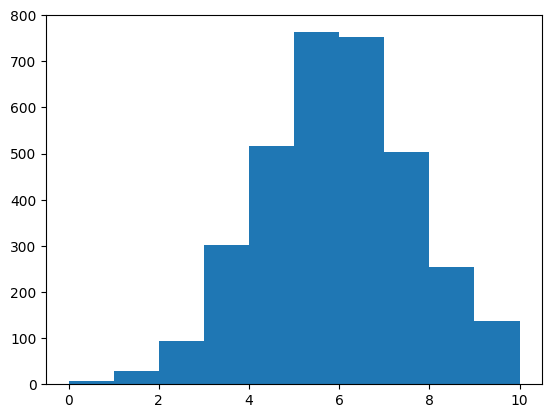

In [15]:
## Generating random samples from a normal distribution with mean = 5, SD = 1.7
## The number of random samples equals the number of users, hence each user is mapped with a random sample
## The sample value mapped with the user indicates, how many random groups can the user be part of

group_count_samples = np.random.normal(loc=5, scale=1.7, size=len(user_list))
for sample_index in range(len(group_count_samples)):
  group_count_samples[sample_index] = int(math.ceil(group_count_samples[sample_index]))

## Visualising the distribution
plt.hist(group_count_samples, bins = [0,1,2,3,4,5,6,7,8,9,10])
plt.show()

In [36]:
## Creating a dictonary of available groups count for every user {user alias : group count}
user_groupcount_dicton = {}
group_count_samples = list(group_count_samples)
for i in range(len(user_list)):
  user_groupcount_dicton[i] = group_count_samples[i]

In [37]:
## Creating list of users who are available for grouping, initially it is set of users
available_user_list = list(user_groupcount_dicton.keys())

In [ ]:
## Group Formation Loop

groups=[]
total_users = len(user_groupcount_dicton)

for user_alias in tqdm.tqdm(user_groupcount_dicton):
    grp_to_create = user_groupcount_dicton[user_alias]
    pointer = 5
    while (grp_to_create > 0) :
      temp_list = []
      temp_list.append(user_alias)
      user_groupcount_dicton[user_alias] = user_groupcount_dicton[user_alias] - 1
      users_added = 1
      attempts = 0
      while(users_added < pointer and attempts < 40):
        user2_alias = available_user_list[random.randint(0,len(available_user_list)-1)]
        if (user_groupcount_dicton[user2_alias]<=0):
          available_user_list.remove(user2_alias)
        attempts = attempts + 1
        if (user2_alias != user_alias and user_groupcount_dicton[user2_alias]>0 and user2_alias not in temp_list):
          temp_list.append(user2_alias)
          user_groupcount_dicton[user2_alias] = user_groupcount_dicton[user2_alias] -1
          users_added = users_added + 1

      groups.append(temp_list)
      pointer = pointer + 1
      if(pointer == 11):
        pointer = 5

      grp_to_create =  grp_to_create - 1

    try:
        available_user_list.remove(user_alias)
    except:
        pass

In [40]:
print("Total number of groups created :", len(groups))

Total number of groups created : 2812


In [41]:
## Seperating the groups based on size
groups_five = []
groups_six = []
groups_seven = []
groups_eight = []
groups_nine = []
groups_ten = []

for group in tqdm.tqdm(groups):
  if(len (group)==5):
    groups_five.append(group)
  if(len (group)==6):
    groups_six.append(group)
  if(len (group)==7):
    groups_seven.append(group)
  if(len (group)==8):
    groups_eight.append(group)
  if(len (group)==9):
    groups_nine.append(group)
  if(len (group)==10):
    groups_ten.append(group)

100%|██████████| 2812/2812 [00:00<00:00, 362402.30it/s]


In [44]:
## Creating final groups with user id by swapping alias

user_id_groups_five = []
for group in groups_five:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_five.append(templist)

user_id_groups_six = []
for group in groups_six:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_six.append(templist)


user_id_groups_seven = []
for group in groups_seven:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_seven.append(templist)


user_id_groups_eight = []
for group in groups_eight:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_eight.append(templist)


user_id_groups_nine = []
for group in groups_nine:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_nine.append(templist)


user_id_groups_ten = []
for group in groups_ten:
  templist = []
  for user in group:
    templist.append(user_alias_id_map[user])
  user_id_groups_ten.append(templist)

In [45]:
print(len(user_id_groups_five),len(user_id_groups_six),len(user_id_groups_seven),len(user_id_groups_eight),len(user_id_groups_nine),len(user_id_groups_ten))

896 693 508 352 235 127


In [46]:
## Saving the created groups
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_5','wb')as f:
  pickle.dump(user_id_groups_five, f)

with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_6','wb')as f:
  pickle.dump(user_id_groups_six, f)

with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_7','wb')as f:
  pickle.dump(user_id_groups_seven, f)

with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_8','wb')as f:
  pickle.dump(user_id_groups_eight, f)

with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_9','wb')as f:
  pickle.dump(user_id_groups_nine, f)

with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_group_10','wb')as f:
  pickle.dump(user_id_groups_ten, f)

## Inference